This notebook is the second in the series from [Run or Walk project](https://github.com/vmalyi/run-or-walk/blob/master/README). 

In this notebook, multi-layer neural network will be trained and evaluated based on data from [Run or Walk Reduced dataset](https://www.kaggle.com/vmalyi/run-or-walk-reduced). Note that this *Run or Walk Final* dataset uses only the subset of data from the original [Run or Walk dataset](https://www.kaggle.com/vmalyi/run-or-walk).

See [Run or Walk Dataset Analysis and Visualization](https://www.kaggle.com/vmalyi/run-or-walk-data-analysis-and-visualization) notebook first in order to get first impression about the dataset used here.

## 1. Manage imports

In [1]:
import os
from datetime import datetime
import keras
import numpy
import pandas as pd
import shutil

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

## 2. Load Dataset

In [2]:
df = pd.read_csv('final_df_accX_only.csv')
#df = pd.read_csv('accel_x_final_dataset.csv')

dataset = df.values

X = dataset[:,0:46].astype(float) # sensor data
Y = dataset[:,46].astype(int) # labels
#X = dataset[:,0:12].astype(float) # sensor data
#Y = dataset[:,12].astype(int) # labels

## 3. Define Neural Network Model

Multi-layer neural network with 3 hidden layers 15 units each, all with *relu* activation function. 

Input layer consists of 12 units. Output layer consits of 2 units, representing *walk* and *run* activities predicted by the model.

In [3]:
def create_model():
    # Define model
    global model
    model = Sequential()
    model.add(Dense(15, input_dim=46, activation='relu'))
    #model.add(Dense(15, input_dim=12, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## 4. Configure model callbacks including early stopping routine

In [4]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
loss_history = LossHistory()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

## 5. Assemble classifier and train it

In [5]:
from keras.utils.np_utils import to_categorical

estimator = KerasClassifier(create_model, epochs=200, batch_size=100, verbose=False)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=5)
Y_test = to_categorical(Y_test)

results = estimator.fit(X_train, Y_train, callbacks=[loss_history, early_stopping,tensorboard_callback], validation_data=(X_test, Y_test))

## 6. Perform 10-fold cross-validation on validation data

In [6]:
kfold = KFold(n_splits=10, shuffle=True, random_state=5)
cv_results = cross_val_score(estimator, X_test, Y_test, cv=kfold)
print("Baseline on test data: %.2f%% (%.2f%%)" % (cv_results.mean()*100, cv_results.std()*100))

Baseline on test data: 80.43% (4.47%)


## 7. Plot accuracy for train and validation data

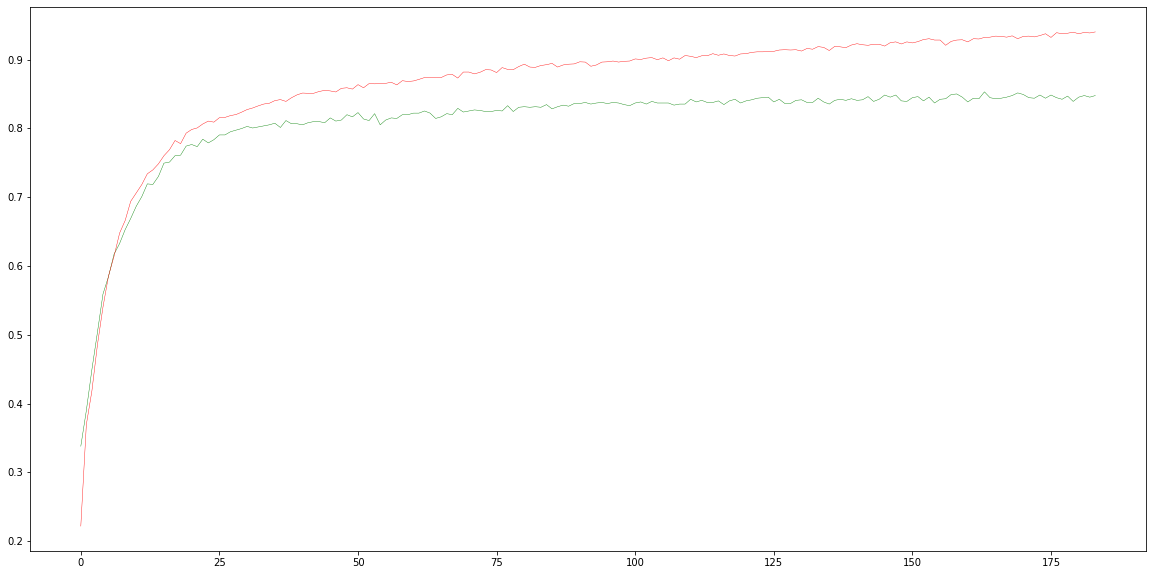

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

figsize = (20, 10)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(results.history['val_accuracy'], linewidth=0.4, color="green")
ax.plot(results.history['accuracy'], linewidth=0.4, color="red")
plt.figure()
plt.show()